# Hidden Markov models

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown

## Definition of the model

We consider a hidden Markov model with two states: *F* representing a fair coin and *B* representing a biased coin. Internally these states are represented by numbers 0 and 1, respectively. 

The fair coin state emits both head (0) and tail (1) with equal probability 0.5. The biased coin state emits tail (1) with higher probability.

In [50]:
# names of states 0 and 1
stateNames = ["F", "B"]
# names of emission characters 0 and 1
emissionNames = ["h", "t"]

# matrix of transition probabilities: 
# value in row i and column j is the probability
# of transitioning from state i to state j
trueTransitionMatrix = np.array(
    [[0.95, 0.05],
    [0.05, 0.95]]
    )
# matrix of emission probabilities:
# value in row i and column j is the probability
# of emiting symbol j in state i
trueEmissionMatrix = np.array(
    [[0.5,0.5],
     [0.2,0.8]]
     )

# check matrix sizes
assert trueTransitionMatrix.shape == (len(stateNames), len(stateNames))
assert trueEmissionMatrix.shape == (len(stateNames), len(emissionNames))

# model will always start in a fixed state
startState = 0
# the length of the training sequence
trainingSeqLength = 100
# the length of the testing sequence
testingSeqLength = 200

Note that the code below works with models with arbitrary number of states and arbitrary sizes of emission alphabets, as long as both states and symbols are numbered internally 0,1,... The only exception is the final visualization which assumes 2 states and 2 emission symbols.

## Auxiliary functions

In [51]:
def sequenceToStr(sequence, alphabet):
  """Convert a sequence of state numbers to a string 
  according to an alphabet such as stateNames or emissionNames"""
  return "".join([alphabet[x] for x in sequence])

def normalize(matrix):
  """Rescale the input numpy 2d matrix so that the sum of each row is 1"""
  (rows, columns) = matrix.shape
  # create a column of row sums
  rowSums = np.sum(matrix, axis=1).reshape((rows, 1))
  # divide by row sums
  return matrix / rowSums

def displayMatrix(matrix, rowNames, columnNames):
  df = pd.DataFrame(matrix, columns=columnNames, index=rowNames)
  display(df)

def stateIntervals(states, whichState):
  """Returns list of pairs (start,end) defining half-open intervals
  of positions where input sequence of states has whichState"""
  intervals = []
  start = None
  for position in range(len(states)):
    if (states[position] == whichState and 
        (position == 0 or states[position - 1] != whichState)):
      assert start is None
      start = position
    if states[position] != whichState and start is not None:
      intervals.append((start, position))
      start = None
  if start is not None:
    intervals.append((start, len(states)))
  return intervals


## Generating random data from the model

We will generate both training and testing data by simmulating the HMM.

In [52]:
def generateFromModel(transitionMatrix, emissionMatrix, startState, seqLength):
  """Randomly generates and returns a list of state numbers 
  and a list of emission symbols according to the given transition 
  and emission probabilities, starting in startState 
  and producing sequences of lenght seqLength. """

  # extract and check matrix sizes
  (numStates, alphabetSize) = emissionMatrix.shape
  assert transitionMatrix.shape == (numStates, numStates)
  assert 0 <= startState < numStates
  
  # start in the given start state
  state = startState
  # create lists of states and emitted symbols
  states = []
  emissions = []

  for repeat in range(seqLength):
    # in each step, select emission according to current state
    emission = np.random.choice(alphabetSize, p=emissionMatrix[state])
    # add state and emission to vectors
    states.append(state)    
    emissions.append(emission)
    # randomly move to the next statee
    state = np.random.choice(numStates, p=transitionMatrix[state])

  return (states, emissions)

In [53]:
(trainingStates, trainingEmissions) = generateFromModel(
    trueTransitionMatrix, trueEmissionMatrix, startState, trainingSeqLength
    )

(testingStates, testingEmissions) = generateFromModel(
    trueTransitionMatrix, trueEmissionMatrix, startState, testingSeqLength
    )

displayLength = 60
display(Markdown(f"**The first {displayLength} states in training:**"))
print(sequenceToStr(trainingStates[:displayLength], stateNames))
display(Markdown(f"**The first {displayLength} emitted symbols in training:**"))
print(sequenceToStr(trainingEmissions[:displayLength], emissionNames))
print()
display(Markdown(f"**The first {displayLength} states in testing:**"))
print(sequenceToStr(testingStates[:displayLength], stateNames))
display(Markdown(f"**The first {displayLength} emitted symbols in testing:**"))
print(sequenceToStr(testingEmissions[:displayLength], emissionNames))


**The first 60 states in training:**

FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBFFFFFFFFFBBBBBB


**The first 60 emitted symbols in training:**

hhthhhhhhhthhhththhthhththhhttttthhhhhthtthtthttthhthtttthht



**The first 60 states in testing:**

FFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBFFFFFFFFFFFFFFFFF


**The first 60 emitted symbols in testing:**

hhttttttttttthtttttthhtttthhtttttthttthttttttththhhthhhthhtt


## Training the model on full data (both states and emisssions)

In [54]:
def trainHMM(states, emissions, numStates, alphabetSize):
  """Returns transition and emission matrices trained on a given 
  pair of state sequence and emitted sequence. 
  The number of states and the size of emission alphabet are given."""

  seqLength = len(states)
  assert seqLength == len(emissions)
  
  # initialize matrices with zeroes
  transitionMatrix = np.zeros((numStates, numStates))
  emissionMatrix = np.zeros((numStates, alphabetSize))

  # count transitons between successive states
  for i in range(seqLength-1):
    transitionMatrix[states[i], states[i+1]] += 1
  # count emissions from each state
  for i in range(seqLength):
    emissionMatrix[states[i], emissions[i]] += 1

  # normalize matrices to have rows summing to 1
  # and return them 
  return (normalize(transitionMatrix), normalize(emissionMatrix))

In [55]:
(trainedTransitionMatrix, trainedEmissionMatrix) = trainHMM(
    trainingStates, trainingEmissions, len(stateNames), len(emissionNames)
    )

display(Markdown("**True transition matrix:**"))
displayMatrix(trueTransitionMatrix, stateNames, stateNames)
display(Markdown("**Trained transition matrix:**"))
displayMatrix(trainedTransitionMatrix, stateNames, stateNames)
print()

display(Markdown("**True emission matrix:**"))
displayMatrix(trueEmissionMatrix, stateNames, emissionNames)
display(Markdown("**Trained emission matrix:**"))
displayMatrix(trainedEmissionMatrix, stateNames, emissionNames)

**True transition matrix:**

F     B
F  0.95  0.05
B  0.05  0.95

**Trained transition matrix:**

F         B
F  0.975000  0.025000
B  0.105263  0.894737

**True emission matrix:**

h    t
F  0.5  0.5
B  0.2  0.8

**Trained emission matrix:**

h         t
F  0.629630  0.370370
B  0.157895  0.842105

## Viterbi algorithm

In [56]:
def viterbi(transitionMatrix, emissionMatrix, startState, emissions):
  """Predicts the most probable state sequence for a given emission sequence
  and model. Beware: for long sequences this implementation 
  will suffer from numerical problems (underflow)"""

  # extract and check matrix sizes
  (numStates, alphabetSize) = emissionMatrix.shape
  assert transitionMatrix.shape == (numStates, numStates) 
  seqLength = len(emissions)

  # initialize dynamic programming table dp, filled with 0
  # and integer matrix of back pointers dpBack
  dp = np.zeros((seqLength, numStates))
  dpBack = np.zeros((seqLength, numStates), dtype=np.uint32)

  # at position 0, only startState has non-zero value
  dp[0, startState] = emissionMatrix[startState, emissions[0]]

  # iterate over all positions and states
  for position in range(1, seqLength):
    for state in range(numStates):
      # iterate over possible previous states
      # and find the most probable option
      maxProb = -1
      maxState = 0
      for prevState in range(numStates):
        prob = (dp[position-1, prevState] 
                * transitionMatrix[prevState, state] 
                * emissionMatrix[state, emissions[position]])
        if prob > maxProb:
          maxProb = prob
          maxState = prevState

      # store the maximum in the matrices
      dp[position, state] = maxProb
      dpBack[position, state] = maxState
  
  # finally extract the state sequence
  # starting with the state with highest value 
  # at the end of the sequence, and going backwards
  state = np.argmax(dp[seqLength-1,:])
  states = [state]
  for position in range(seqLength-1, 0, -1):
    state = dpBack[position, state]
    states.append(state)

  # we have to reverse the list of states
  states = list(reversed(states))
  return states

In [57]:
# call Viterbi algorithm on testing emssions 
# using model estimated from training data
viterbiStates = viterbi(
    trainedTransitionMatrix, trainedEmissionMatrix, startState, testingEmissions
    )

# print results
displayLength = 60
display(Markdown(f"**The first {displayLength} states in true answer:**"))
print(sequenceToStr(testingStates[:displayLength], stateNames))

display(Markdown(f"**The first {displayLength} states in Viterbi answer:**"))
print(sequenceToStr(viterbiStates[:displayLength], stateNames))

display(Markdown(f"**The first {displayLength} emissions:**"))
print(sequenceToStr(testingEmissions[:displayLength],emissionNames))


**The first 60 states in true answer:**

FFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBFFFFFFFFFFFFFFFFF


**The first 60 states in Viterbi answer:**

FFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBFFFFFFFFFFFFFF


**The first 60 emissions:**

hhttttttttttthtttttthhtttthhtttttthttthttttttththhhthhhthhtt


## Forward algorithm

In [58]:
def forward(transitionMatrix, emissionMatrix, startState, emissions):
  """Computes for each position i and state u probability of 
  generating the first i emission symbols and endng in state u.
  Beware: for long sequences this implementation 
  will suffer from numerical problems (underflow)"""

  # extract and check matrix sizes
  (numStates, alphabetSize) = emissionMatrix.shape
  assert transitionMatrix.shape == (numStates, numStates) 
  seqLength = len(emissions)

  # initialize the dynamic programming matrix with zeroes
  dp = np.zeros((seqLength, numStates))
  # at position 0, only startState has non-zero value
  dp[0, startState] = emissionMatrix[startState, emissions[0]]

  # iterate over all positions and states
  for position in range(1, seqLength):
    for state in range(numStates):
      # sum up contributions from all preceding states
      sum = 0
      for prevState in range(numStates):
        prob = (dp[position-1, prevState] 
                * transitionMatrix[prevState, state] 
                * emissionMatrix[state, emissions[position]])
        sum += prob 
      # store the sum in dp matrix       
      dp[position, state] = sum
    
  # return the dp matrix
  return dp

In [59]:
# run the forward algorithm on testing emissions
forwardDp = forward(trainedTransitionMatrix, trainedEmissionMatrix, startState, testingEmissions)
# now normalize probabilities for each position to sum to 1
forwardProb = normalize(forwardDp)

# print probabilities for several first positions before and after normalization
# use transposed matrix to save space
displayLength = 8
posNames = [str(x) for x in range(displayLength)]
display(Markdown(f"**The values for the first {displayLength} positions from the forward matrix:**"))
displayMatrix(forwardDp[:displayLength, ].transpose(), stateNames, posNames)

print()
display(Markdown(f"**The probabilities for the first {displayLength} positions from the normalized matrix:**"))
displayMatrix(forwardProb[:displayLength, ].transpose(), stateNames, posNames)

print()
display(Markdown(f"**The first {displayLength} emissions:**"))
print(sequenceToStr(testingEmissions[:displayLength],emissionNames))


**The values for the first 8 positions from the forward matrix:**

0         1         2         3         4         5         6  \
F  0.62963  0.386523  0.139675  0.050828  0.018763  0.007125  0.002852   
B  0.00000  0.002485  0.010010  0.010483  0.008968  0.007152  0.005539   

          7  
F  0.001246  
B  0.004233

**The probabilities for the first 8 positions from the normalized matrix:**

0         1         2         3         4         5         6         7
F  1.0  0.993611  0.933126  0.829025  0.676603  0.499053  0.339876  0.227364
B  0.0  0.006389  0.066874  0.170975  0.323397  0.500947  0.660124  0.772636

**The first 8 emissions:**

hhtttttt


## Visualization


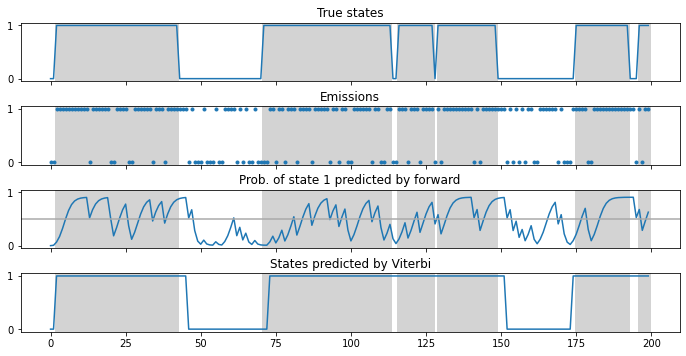

In [60]:
(figure, axes) = plt.subplots(4, 1, sharey=True, sharex=True, 
                              figsize=(10, 5))
figure.tight_layout(pad=1.5)
axes[0].plot(testingStates)
axes[0].set_title("True states")
axes[1].plot(testingEmissions, '.')
axes[1].set_title("Emissions")
axes[2].plot(forwardProb[:,1])
axes[2].axhline(0.5, color="darkgray")
axes[2].set_title("Prob. of state 1 predicted by forward")
axes[3].plot(viterbiStates)
axes[3].set_title("States predicted by Viterbi")

intervals = stateIntervals(testingStates, 1)
for (start, end) in intervals:
    for ax in axes:
      ax.axvspan(start-0.5, end-0.5, color="lightgray")

figure.show()

The plot shows true states in the testimg sequence(0 = *F*, 1 = *B*), emissions (0 = *h*, 1 = *t*), forward probability of state 1 along the sequence, and states predicted by Viterbi. 

Light gray areas show parts of the sequence emitted by state *B*. Horizontal line in the forward plot represents 0.5. 